# Notebook A — “Laat runnen” (Smoke test)

This notebook is a **one-click end‑to‑end run** to confirm the codebase is wired correctly.

**What this notebook does**
1. Builds a grid from a PPW rule (`grid_from_ppw`) with a minimum size.
2. Resolves a case via `make_default_cases()` and builds the medium `c(x,y)`.
3. Builds a simple RHS forcing (tries `assemble_rhs`, otherwise uses a Gaussian fallback).
4. Assembles the Helmholtz operator **without PML** (Dirichlet boundary path).
5. Solves the sparse linear system (uses your solver if available, otherwise `spsolve`).
6. Checks residual `||Au-f||/||f||`.
7. Produces a few canonical plots.

**Design principle**
- This notebook should remain stable even while you refactor PML and other parts.
- No tuning, no sweeps: just “does it run and produce sensible output?”.

---

If you get an error, it’s usually one of:
- API mismatch (function signature changed),
- case name not found,
- missing imports due to file moves.


In [1]:
from __future__ import annotations

import numpy as np
import scipy.sparse.linalg as spla

# --- Project imports ---
from core.config import HelmholtzConfig
from core.resolution import grid_from_ppw
from core.cases import make_default_cases
from core.medium import build_medium

from operators.assemble import assemble_helmholtz_matrix
from diagnostics import plot_field

print("Imports OK")

Imports OK


## 1) Parameters (keep this small and boring)

Pick a single test setup that is:
- **fast enough** to run often,
- **representative enough** to catch wiring bugs.

Notes:
- For smoke testing, a grid like 201×201 or 301×301 is usually plenty.
- Keep `case_name` as a known key (e.g. `"const"`).

In [2]:
# --- PDE / grid ---
omega = 32.0
ppw_target = 10.0

lx, ly = 1.0, 1.0
n_min = 501
make_odd = True

# Conservative lower bound used by grid builder (affects spacing)
c_min_for_grid = 1.0

# --- Case selection ---
case_name = "const"

# --- RHS fallback (only used if assemble_rhs fails) ---
gauss_sigma = 0.05

print("Params set.")

Params set.


## 2) Build grid + config (Dirichlet baseline)

Here we explicitly set `pml=None` (or just omit it) to force the **Dirichlet** assembly path.


In [3]:
grid = grid_from_ppw(
    omega=omega,
    ppw=ppw_target,
    lx=lx,
    ly=ly,
    c_min=c_min_for_grid,
    n_min=n_min,
    make_odd=make_odd,
)

cfg = HelmholtzConfig(
    omega=omega,
    grid=grid,
    pml=None,  # baseline Dirichlet
)

print(f"Grid: {cfg.grid.nx} x {cfg.grid.ny}, hx={cfg.grid.hx:.4g}, hy={cfg.grid.hy:.4g}")
print("PML enabled:", cfg.pml is not None)

Grid: 501 x 501, hx=0.002, hy=0.002
PML enabled: False


## 3) Resolve case and build medium `c(x,y)`

`build_medium(cfg, case_cfg, X, Y)` expects a **CaseConfig**, not a string.
So we resolve `case_name` via `make_default_cases()`.

We also print `min(c), max(c)` as a quick sanity check.


In [4]:
cases = make_default_cases()

if hasattr(cases, "keys"):
    if case_name not in cases:
        raise KeyError(f"case_name={case_name} not found. Available: {list(cases.keys())}")
    case_cfg = cases[case_name]
else:
    # list-style fallback
    case_cfg = next(cc for cc in cases if getattr(cc, "name", None) == case_name)

X, Y = cfg.grid.mesh()
c = build_medium(cfg, case_cfg, X, Y)

print("Medium built.")
print("min(c) =", float(np.min(c)), "max(c) =", float(np.max(c)))

Medium built.
min(c) = 1.0 max(c) = 1.0


## 4) Build RHS `f`

We try your project's `assemble_rhs` first. If it doesn’t match the signature you expect,
we fall back to a centered Gaussian forcing.

This fallback is intentionally simple and robust: it’s great for smoke tests.


In [5]:
# Try project RHS builder if available
try:
    from core.rhs import assemble_rhs  # type: ignore
    f = assemble_rhs(cfg)  # many projects implement assemble_rhs(cfg) without extra args
    f = np.asarray(f).reshape(-1)
    print("RHS built via core.rhs.assemble_rhs(cfg).")
except Exception as e:
    # Fallback Gaussian in physical coords if possible; otherwise assume [0,lx]×[0,ly]
    if hasattr(cfg.grid, "xmin") and hasattr(cfg.grid, "xmax"):
        x0 = 0.5 * (cfg.grid.xmin + cfg.grid.xmax)
        y0 = 0.5 * (cfg.grid.ymin + cfg.grid.ymax)
    else:
        x0, y0 = 0.5 * lx, 0.5 * ly

    g = np.exp(-((X - x0) ** 2 + (Y - y0) ** 2) / (2 * gauss_sigma**2))
    f = g.reshape(-1)

    print("assemble_rhs unavailable or incompatible; used fallback Gaussian.")
    print("Reason:", type(e).__name__)

print("RHS shape:", f.shape)

assemble_rhs unavailable or incompatible; used fallback Gaussian.
Reason: TypeError
RHS shape: (251001,)


## 5) Assemble operator `A` and solve

We assemble using `assemble_helmholtz_matrix(cfg, c)`.

Then solve the sparse system. We try your project's solver if present; otherwise we use `spsolve`.


In [6]:
A = assemble_helmholtz_matrix(cfg, c)
print("A shape:", A.shape, "nnz:", A.nnz)

# Try project solver if available
try:
    from operators.solve import solve_linear_system  # type: ignore
    u = solve_linear_system(A, f)
    print("Solved via operators.solve.solve_linear_system")
except Exception as e:
    u = spla.spsolve(A, f)
    print("Solved via scipy.sparse.linalg.spsolve (fallback)")
    print("Reason:", type(e).__name__)

u = np.asarray(u).reshape(-1)
print("Solved. ||u||2 =", float(np.linalg.norm(u)))

A shape: (251001, 251001) nnz: 1247005
Solved via operators.solve.solve_linear_system
Solved. ||u||2 = 0.3026540148553955


## 6) Residual check: `||Au - f|| / ||f||`

This is the single most important smoke-test scalar:
- If it's huge (e.g. `>1e-3`), something is wrong.
- With a direct solve, you often see `~1e-10`–`1e-8` (depends on conditioning).


In [7]:
r = A @ u - f
rel_res = float(np.linalg.norm(r) / (np.linalg.norm(f) + 1e-30))
print("Relative residual ||Au-f||/||f|| =", rel_res)

Relative residual ||Au-f||/||f|| = 2.2818206375847364e-12


## 7) Plots

We plot:
- `|u|`
- `log10|u|`

These are the two canonical “does this look sane?” visuals.

Tip: if `|u|` is dominated by a few spikes, use `clip_quantile=0.999`.


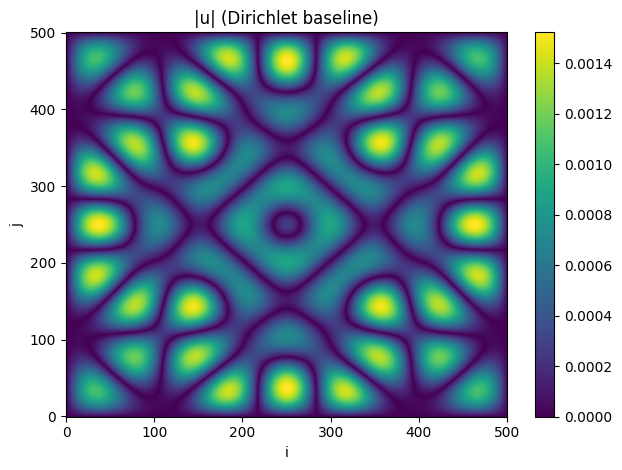

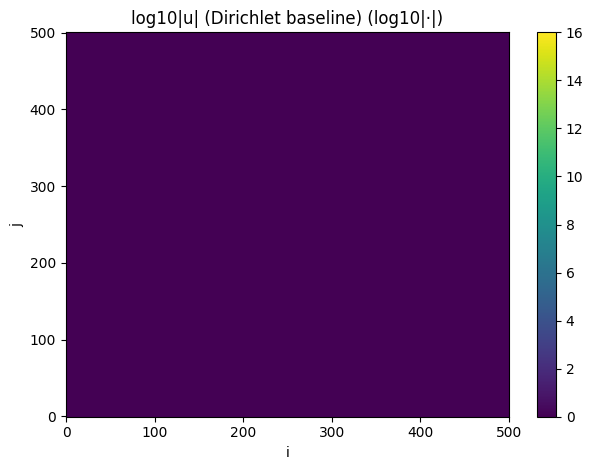

In [8]:
from pathlib import Path

outdir = Path("outputs/notebookA")
outdir.mkdir(parents=True, exist_ok=True)

plot_field(cfg, u, title="|u| (Dirichlet baseline)", mode="abs",
           clip_quantile=0.999, show=True, path=outdir/"u_abs.png")

plot_field(cfg, u, title="log10|u| (Dirichlet baseline)", mode="logabs",
           clip_quantile=0.999, show=True, path=outdir/"u_logabs.png")

## 8) Quick exit criteria

If all of these are true, Notebook A “passes”:
- it runs end-to-end without manual edits
- the residual is small (context dependent)
- plots render and look consistent run-to-run

Next notebook to work on: **Notebook B (Make PML profiles)**.
